In [2]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import sklearn.tree as tree

#tensorflow
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Input

# others
from copy import deepcopy
from xgboost import XGBRegressor, XGBClassifier

# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES

2022-04-23 07:14:32.723247: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# Split the stations by the number of samples available
columns = deepcopy(LABELS)
columns.extend(["season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp season_wet elevation lat lon 

# Single model comparison

In [3]:
Xtrain = np.array(df_train[columns])
Xtest = np.array(df_test[columns])

Ytrain = np.array(df_train['data_in'])
Ytest = np.array(df_test['data_in'])

model = XGBRegressor()
model.fit(Xtrain, Ytrain)
yhat = model.predict(Xtest)

In [4]:
mean_squared_error(Ytest, yhat, squared=False)

4.41924342477992

In [5]:
model = LinearRegression()
model.fit(Xtrain, Ytrain)
yhat = model.predict(Xtest)

In [6]:
mean_squared_error(Ytest, yhat, squared=False)

5.779447159157981

# Site-specific comparison

In [7]:
np.random.seed(42)
scaler = StandardScaler()
# skn = df_combined['skn'].sample().values[0]
skn = 380 # bad station
skn = 148.1 # good station
df_station = df_combined[df_combined['skn'] == skn]

train, test = train_test_split(df_station, test_size=0.2, random_state=42)
Xtrain, Ytrain = train[columns], train['data_in']
Xtest, Ytest = test[columns], test['data_in']

Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

#Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
#random_forest = RandomForestRegressor()
#random_forest.fit(Xtrain, Ytrain)
# decision_tree = DecisionTreeRegressor()
# decision_tree.fit(Xtrain, Ytrain)

xgboost = XGBRegressor()
xgboost.fit(Xtrain, Ytrain)
yhat_xgb = xgboost.predict(Xtest)
rmse_xgb = mean_squared_error(Ytest, yhat_xgb, squared=False)

#yhat_rf = random_forest.predict(Xtest)
#rmse_rf = mean_squared_error(Ytest, yhat_rf, squared=False)
#yhat_dt = decision_tree.predict(Xtest)
#rmse_dt = mean_squared_error(Ytest, yhat_dt, squared=False)

linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
yhat_lr = linear_regression.predict(Xtest)
rmse_lr = mean_squared_error(Ytest, yhat_lr, squared=False)

In [8]:
print("RMSE on Linear Regression: {:.3f}\nRMSE on XGB: {:.3f}".format(rmse_lr, rmse_xgb))

RMSE on Linear Regression: 0.960
RMSE on XGB: 1.194


In [9]:
for name, value in zip(columns, linear_regression.coef_):
    print(name, value)

air2m 0.8700461654525813
air1000_500 -3.273079197992303
hgt500 0.02171300514189483
hgt1000 -0.9276286929896446
omega500 -0.08266550105299753
pottemp1000-500 3.488380259175824
pottemp1000-850 0.05311901135017552
pr_wtr -0.3145205465178702
shum-uwnd-700 0.10252976259124565
shum-uwnd-925 0.21486920949376198
shum-vwnd-700 0.16697287570964106
shum-vwnd-950 0.008418502401135505
shum700 0.21517716024223485
shum925 0.5169435892056099
skt -0.5293989443113534
slp 0.7722434303295733
season_wet -0.045963045125867595
elevation 0.0
lat 0.0
lon 0.0


In [10]:
Xtrain.shape

(576, 20)

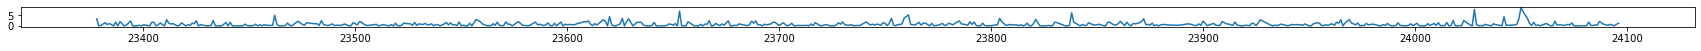

In [11]:
df_temp = train.sort_values(['year', 'month'])
df_temp['cum_month'] = df_temp.apply(lambda row: row['year'] * 12 + row['month'], axis=1)
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.plot(df_temp['cum_month'], df_temp['data_in'])
ax.set_aspect(1)

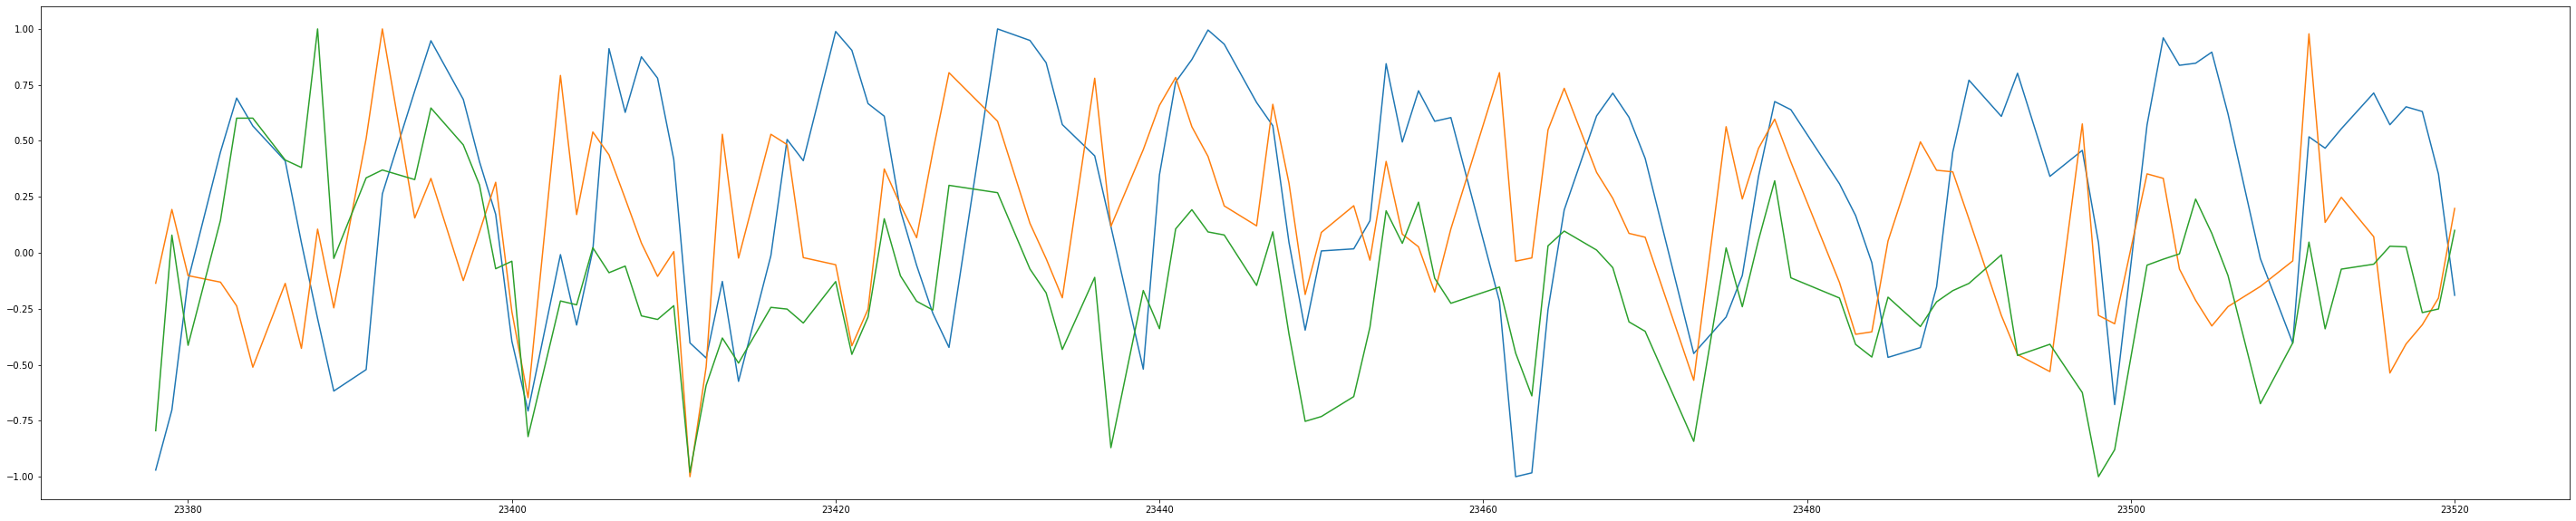

In [12]:
fig, ax = plt.subplots(1, figsize=(50,10))
scaler = MinMaxScaler(feature_range=(-1,1))
df_section = df_temp[df_temp['year'] < 1960]

ax.plot(df_section['cum_month'], scaler.fit_transform(np.array(df_section['hgt500']).reshape(-1, 1)))
ax.plot(df_section['cum_month'], scaler.fit_transform(np.array(df_section['hgt1000']).reshape(-1, 1)))
#ax.plot(df_section['cum_month'], scaler.fit_transform(np.array(df_section['skt']).reshape(-1, 1)))
#ax.plot(df_section['cum_month'], -1 * scaler.fit_transform(np.array(df_section['air1000_500']).reshape(-1, 1)))
# ax.plot(df_temp['cum_month'], scaler.fit_transform(np.array(df_temp['season_wet']).reshape(-1, 1)))
ax.plot(df_section['cum_month'], -1 * scaler.fit_transform(np.array(df_section['shum-uwnd-925']).reshape(-1, 1)))
# ax.plot(df_temp['cum_month'], 1 + df_temp['data_in'])

<AxesSubplot:>

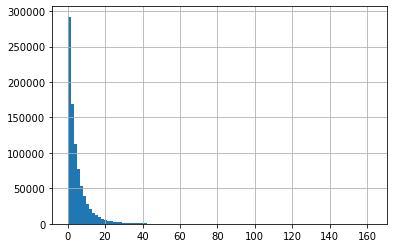

In [109]:
fig, ax = plt.subplots(1)
df_combined['data_in'].hist(bins=100, ax=ax)

## most of the variables are highly correlated

In [16]:
columns

['air2m',
 'air1000_500',
 'hgt500',
 'hgt1000',
 'omega500',
 'pottemp1000-500',
 'pottemp1000-850',
 'pr_wtr',
 'shum-uwnd-700',
 'shum-uwnd-925',
 'shum-vwnd-700',
 'shum-vwnd-950',
 'shum700',
 'shum925',
 'skt',
 'slp',
 'season_wet',
 'elevation',
 'lat',
 'lon']

In [88]:
np.random.seed(42)
# skn = df_combined['skn'].sample().values[0]
skn = 380 # bad station
# skn = 148.1 # good station
df_station = df_combined[df_combined['skn'] == skn]

train, test = train_test_split(df_station, test_size=0.2, random_state=42)
reduced_columns = ['air1000_500', 'pottemp1000-500', 'hgt1000']
Xtrain, Ytrain = train[reduced_columns], train['data_in']
Xtest, Ytest = test[reduced_columns], test['data_in']

xgboost = XGBRegressor()
xgboost.fit(Xtrain, Ytrain)
yhat_xgb = xgboost.predict(Xtest)
rmse_xgb = mean_squared_error(Ytest, yhat_xgb, squared=False)

linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
yhat_lr = linear_regression.predict(Xtest)
rmse_lr = mean_squared_error(Ytest, yhat_lr, squared=False)

In [89]:
print("RMSE on Linear Regression: {:.3f}\nRMSE on XGB: {:.3f}".format(rmse_lr, rmse_xgb))

RMSE on Linear Regression: 18.557
RMSE on XGB: 21.007


# binary classification

In [123]:
df_combined['low'] = df_combined.apply(lambda row: 1 if row['data_in'] < 0.1 else 0, axis=1)

In [136]:
X = df_combined[columns]
Y = df_combined['low']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
xgboost = XGBClassifier()
xgboost.fit(Xtrain, Ytrain)

yhat = xgboost.predict(Xtest)
log_loss(Ytest, yhat)
roc_auc_score(Ytest, yhat)

/home/yusukemh/.conda/envs/climate/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:10:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6743484250528196

In [127]:
df_combined.shape

(865561, 25)